In [2]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: C:\Users\vaibh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [10]:
import yfinance
from datetime import datetime

nifty50_symbol = "^NSEI"

start_date = datetime(2010, 1, 1)
end_date = datetime(2019, 6, 30)

data = yfinance.download(nifty50_symbol, start=start_date, end=end_date)
data.to_csv(f"{nifty50_symbol}.csv")

[*********************100%%**********************]  1 of 1 completed


In [11]:
!pip install pmdarima
import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from pmdarima.arima import auto_arima



stock_data = pd.read_csv(
    '^NSEI.csv', 
    sep=',', 
    index_col='Date', 
    parse_dates=['Date'], 
    date_parser=lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')  )
stock_data

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: C:\Users\vaibh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0
2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0
2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0
2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0
...,...,...,...,...,...,...
2019-06-24,11725.799805,11754.000000,11670.200195,11699.650391,11699.650391,277600
2019-06-25,11681.000000,11814.400391,11651.000000,11796.450195,11796.450195,300500
2019-06-26,11768.150391,11871.849609,11757.549805,11847.549805,11847.549805,327900


### Plot close price

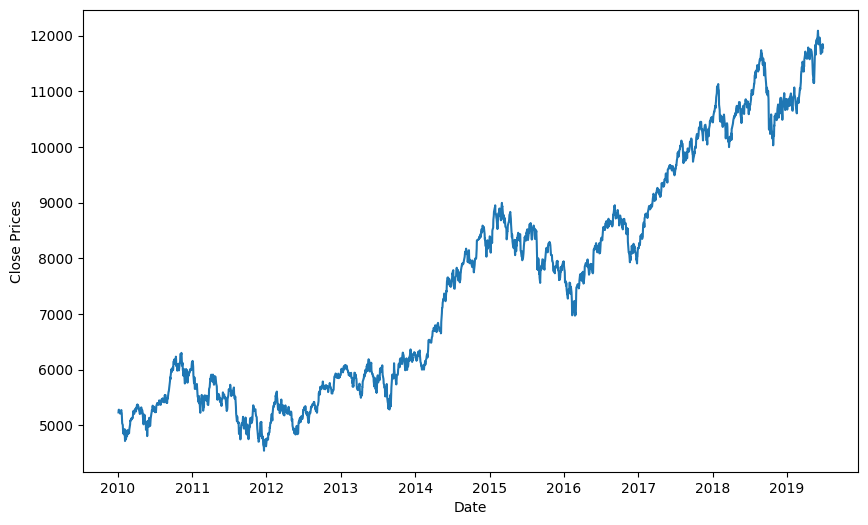

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.show()

### kernel density estimate for closing price

<Axes: ylabel='Density'>

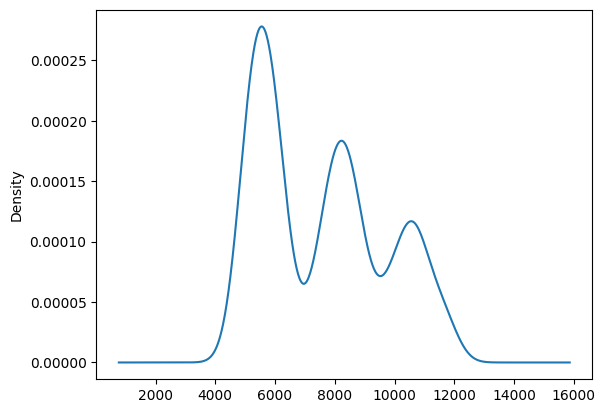

In [13]:
df_close = stock_data['Close']
df_close.plot(kind='kde')

### Rolling Mean and Standard Deviation and Dicky Fuller Test

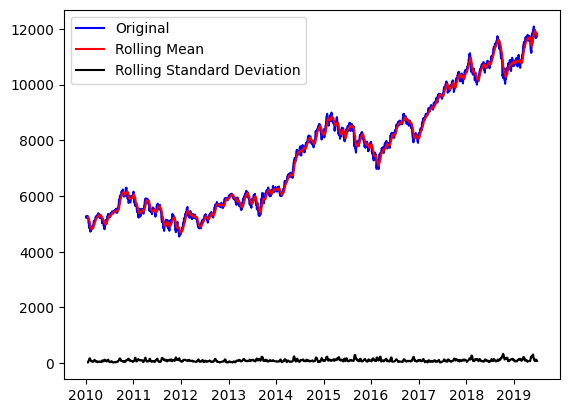

Test Statistics                  -0.020302
p-value                           0.956821
No. of lags used                  1.000000
Number of observations used    2319.000000
critical value (1%)              -3.433173
critical value (5%)              -2.862787
critical value (10%)             -2.567434
dtype: float64


In [14]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.show(block=False)
    
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df_close)

### Some general graphs about the data

<Figure size 640x480 with 0 Axes>

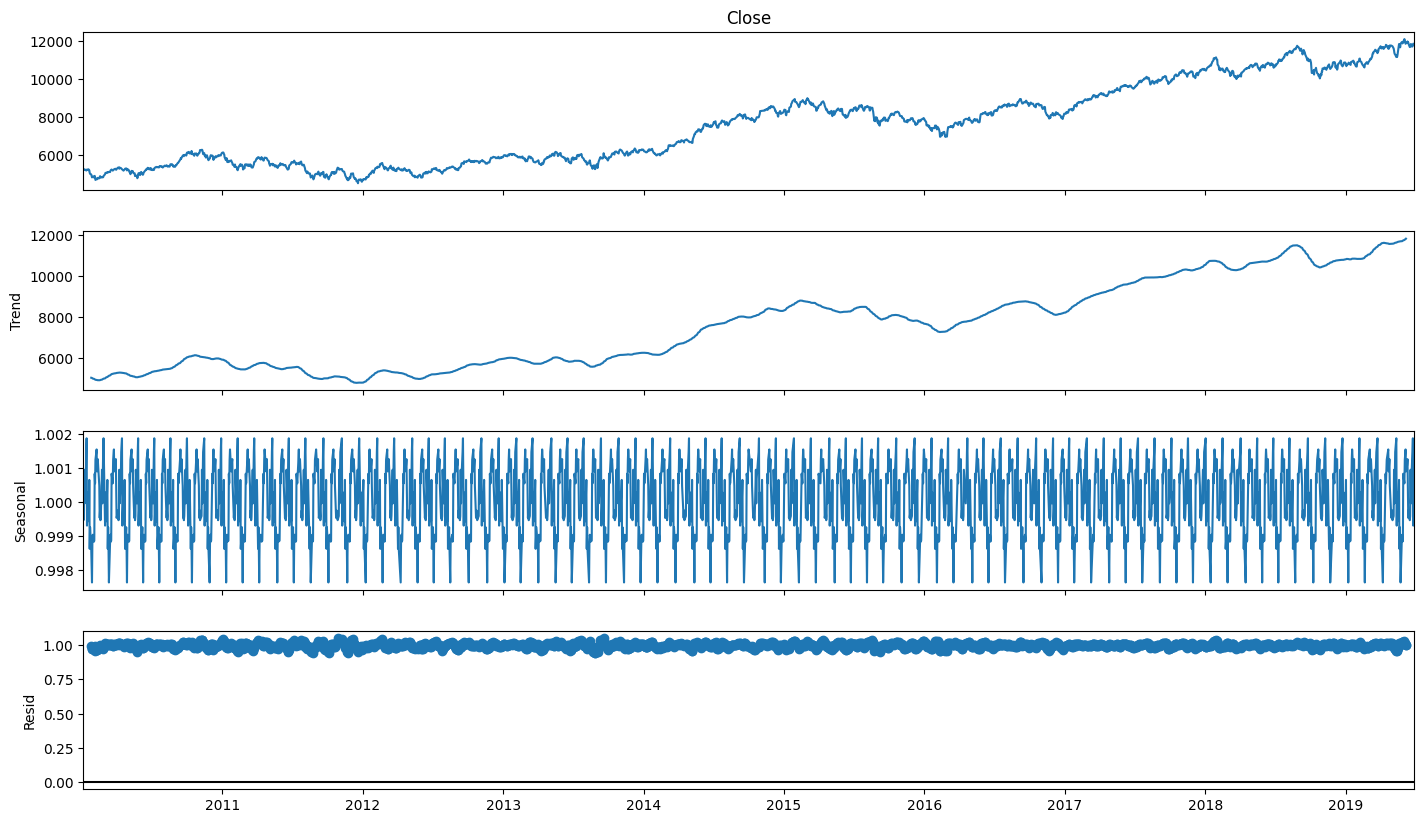

In [15]:
result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

### Moving Average

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


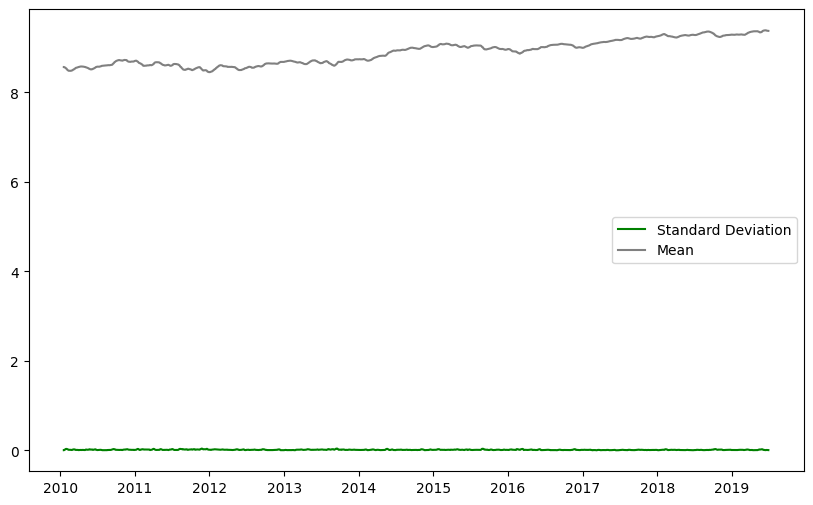

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.plot(std_dev, color ="green", label = "Standard Deviation")
plt.plot(moving_avg, color="grey", label = "Mean")
plt.legend()
plt.show()

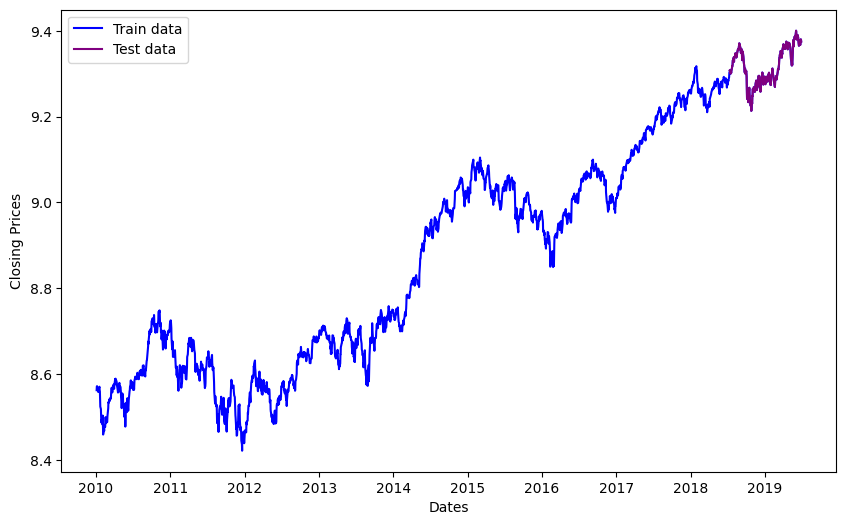

In [17]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'blue', label='Train data')
plt.plot(test_data, 'purple', label='Test data')
plt.legend()

### Defining the model

In [21]:
model_autoARIMA = auto_arima(df_log, 
                             start_p=1, start_q=1,
                             max_p=5, max_q=5, 
                             m=1,  # frequency of series
                             seasonal=True, 
                             d=1, D=1, 
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)
print(model_autoARIMA.summary())
plt.show()



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14903.095, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14895.799, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14904.817, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14905.036, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14894.811, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-14903.127, Time=0.77 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-14902.103, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-14904.414, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 3.589 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2321
Model:               SARIMAX(0, 1, 1)   Log Likelihood                7455.518
Date:                Wed, 14 Aug 2024   AIC                         -14905.036
Time:               

In [82]:
model = ARIMA(train_data, order=(1,1,2)) 
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data, 
                order=(1, 1, 2), 
                seasonal_order=(1, 1, 1, 12))
fitted = model.fit()
print(fitted.summary()) 
fitted = model.fit()  
print(fitted.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                 2085
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 12)   Log Likelihood                6589.686
Date:                              Wed, 14 Aug 2024   AIC                         -13167.373
Time:                                      18:34:51   BIC                         -13133.555
Sample:                                           0   HQIC                        -13154.978
                                             - 2085                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7188      0.074      9.773      0.000       0.575       0.863
ma.L1         -0.67

### Forecasting the data

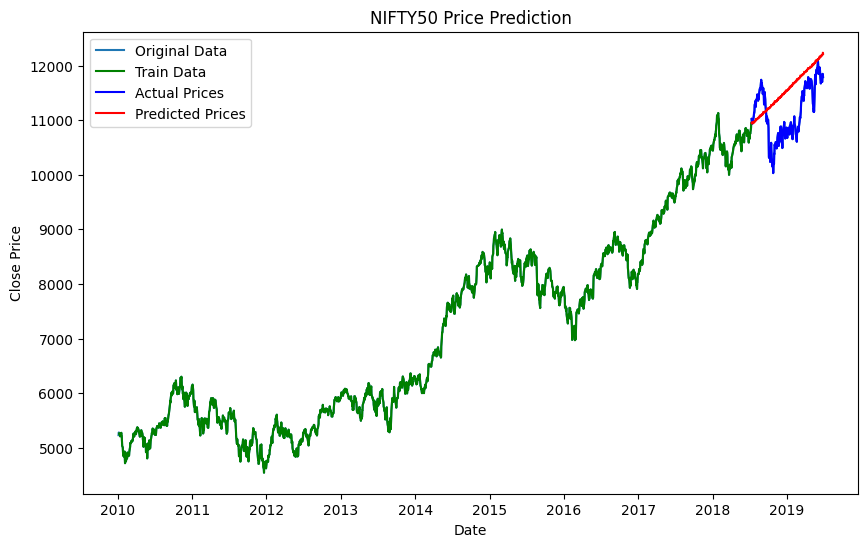

In [83]:

forecasted_values = fitted.forecast(steps=len(test_data))
forecasted_values = np.exp(forecasted_values)

plt.figure(figsize=(10,6))
plt.plot(df_close, label='Original Data')
plt.plot(np.exp(train_data), label='Train Data', color='blue')
plt.plot(test_data.index, np.exp(test_data), label='Actual Prices', color='purple')
plt.plot(test_data.index, forecasted_values, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [84]:
print(forecasted_values)

2085    10951.976409
2086    10939.929418
2087    10938.305874
2088    10965.810063
2089    10946.753058
            ...     
2313    12193.775330
2314    12192.671695
2315    12200.099111
2316    12234.355505
2317    12217.805482
Name: predicted_mean, Length: 233, dtype: float64


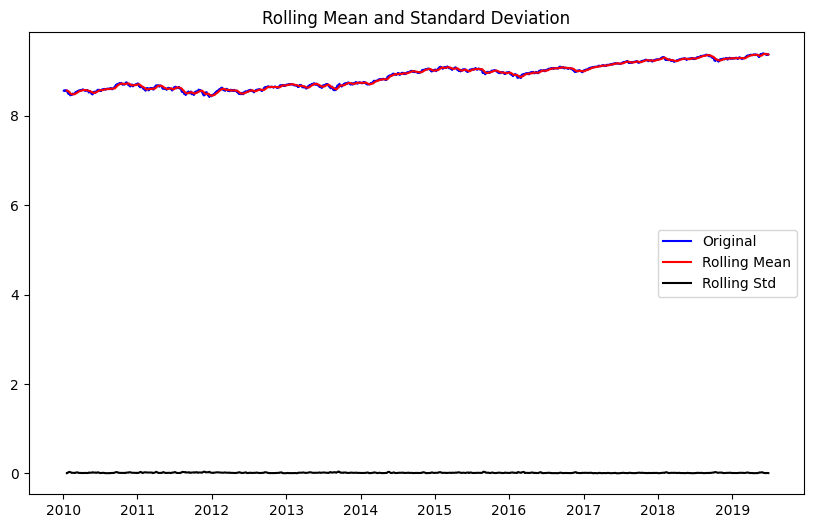

Results of dickey fuller test
Test Statistics                  -0.450452
p-value                           0.901328
No. of lags used                  1.000000
Number of observations used    2319.000000
critical value (1%)              -3.433173
critical value (5%)              -2.862787
critical value (10%)             -2.567434
dtype: float64


In [85]:
test_stationarity(df_log)

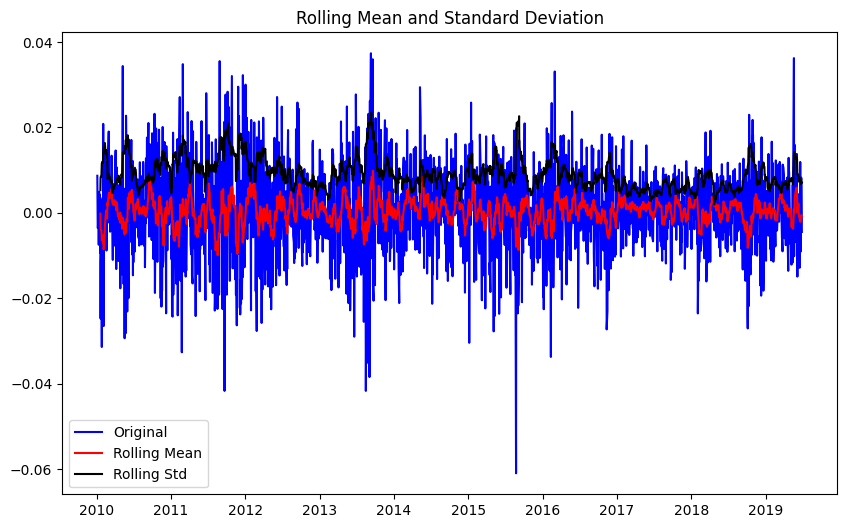

Results of dickey fuller test
Test Statistics                 -44.932868
p-value                           0.000000
No. of lags used                  0.000000
Number of observations used    2319.000000
critical value (1%)              -3.433173
critical value (5%)              -2.862787
critical value (10%)             -2.567434
dtype: float64


In [86]:
df_diff = df_log.diff().dropna()
test_stationarity(df_diff)

# IGNORE

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), forecasted_values)
mae = mean_absolute_error(np.exp(test_data), forecasted_values)
rmse = math.sqrt(mse)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

NameError: name 'test_data' is not defined

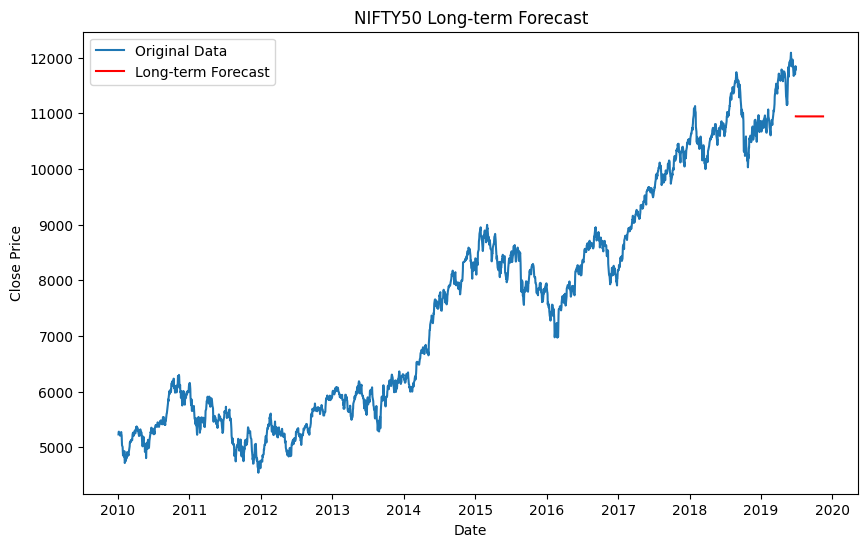

In [52]:
long_term_forecast = fitted.forecast(steps=100)  
long_term_forecast = np.exp(long_term_forecast)

plt.figure(figsize=(10,6))
plt.plot(df_close, label='Original Data')
plt.plot(pd.date_range(start=test_data.index[-1], periods=100, freq='B'), long_term_forecast, label='Long-term Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.title('NIFTY50 Long-term Forecast')
plt.show()


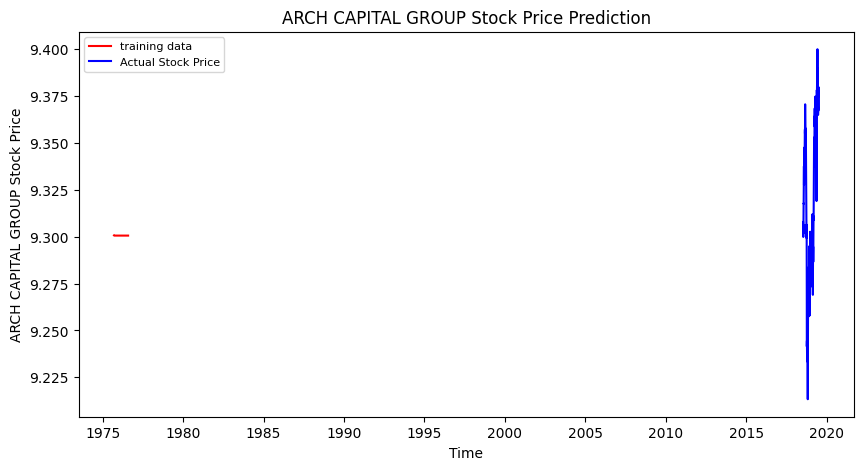

In [49]:
output= fitted.forecast(321, alpha=0.05)

# print(fc,se,conf)
# print(extra)
# Make as pandas series
# fc_series = pd.Series(fc, index=test_data.index)
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
# plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [44]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

InvalidParameterError: The 'y_pred' parameter of mean_squared_error must be an array-like. Got 9.300712862495494 instead.